# Artem Moskalev. Discrete Fourier Transform, Wavelets and Multiresolution Processing

In [1]:
# import the necessary modules

%matplotlib inline

import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from skimage import img_as_float

In [2]:
def show_images(input, input_title, output, output_title):
    fig, (im_input, im_output) = plt.subplots(1, 2, figsize=(15, 35))
    im_input.imshow(input)
    im_input.set_title(input_title)
    im_input.set_axis_off()
    im_output.imshow(output)
    im_output.set_title(output_title)
    im_output.set_axis_off()
    fig.show()

## Exercise 1: Discrete Fourier Transform

The goal of this exercise is to learn how to compute the image representation in the frequency domain using the Discrete Fourier Transform (DFT).

**The task: **

a) Implement the $2D$ "same-size" convolution for zero, mirror and periodic boundary conditions by using the DFT transforms (FFT) of the input image and the impulse response. Your implementation should be based on the convolution theorem. Using the implemented operation compute the convolution of an image with a 2D Gaussian filter and compare the result with the one you obtained from the Hometask #1 (hint: the results should be the same up to machine precision).

b) Use two images and "blend" them in the frequency domain: take the DFT magnitude from the first one and the DFT phase from the second and create a new frequency represantion of a third image. Use the inverse DFT to return to the image domain and plot the resulting image. Report what you observe. Why is this?

/home/art_mos/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


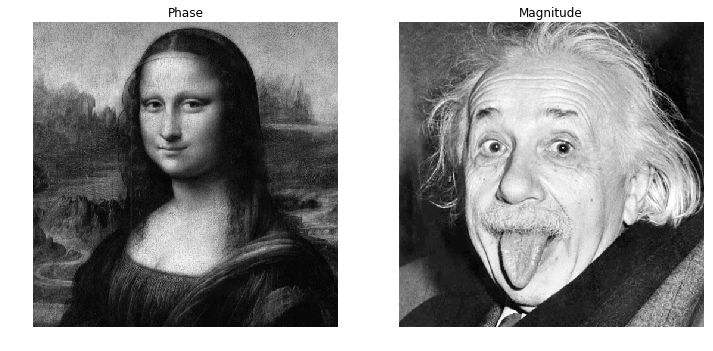

In [3]:
# read images

im_phase = scipy.misc.imread('images/monalisa.jpg')
im_magnutide = scipy.misc.imread('images/alberteinstein.jpg')

# show images

fig, (sp_phase, sp_magnitude) = plt.subplots(1, 2, figsize=(12, 25))
sp_phase.imshow(im_phase, cmap='gray')
sp_phase.set_title("Phase")
sp_phase.set_axis_off()
sp_magnitude.imshow(im_magnutide, cmap='gray')
sp_magnitude.set_title("Magnitude")
sp_magnitude.set_axis_off()
fig.show()

###### A:

In [4]:
# Input your code here
from scipy.signal import convolve2d
from skimage import img_as_float

def convolve_2d(image, kernel, mode='same', boundary='symm'):
    image = np.copy(img_as_float(image))
    
    if image.ndim == 2:
        d1 = image.copy()
        convolved = convolve2d(in1=image, in2=kernel, boundary=boundary, mode=mode)
    elif image.ndim == 3:
        d1, d2, d3 = image[:,:,0].copy(), image[:,:,1].copy(), image[:,:,2].copy()
        convolved0 = convolve2d(in1=d1, in2=kernel, boundary=boundary, mode=mode)
        convolved1 = convolve2d(in1=d2, in2=kernel, boundary=boundary, mode=mode)
        convolved2 = convolve2d(in1=d3, in2=kernel, boundary=boundary, mode=mode)
        convolved = np.stack([convolved0,convolved1,convolved2], axis=2)
    return img_as_float(convolved)

def gaussian_kernel_2d(sigma, radius):
    xx,yy = np.arange(radius),np.arange(radius)
    ii,jj = np.meshgrid(xx,yy)
    ii = ii-radius//2
    jj = jj-radius//2
    ij = ii**2 + jj**2
    gaussian = np.vectorize(lambda x: (2*np.pi*sigma**2)**(-1) * np.exp( -1*x / (2*sigma**2)))
    kernel = gaussian(ij)
    kernel = kernel / np.sum(kernel)
    return kernel

In [5]:
def dftconvolution(image, kernel, mode='same', boundary='zero'):
    
    try:
        d1 = np.copy(img_as_float(image[:,:,0])) #anyway it's gray
    except:
        d1 = np.copy(img_as_float(image))
    
    ker_pad = ((0,image.shape[0]-1),(0,image.shape[1]-1))
    img_pad = ((int(kernel.shape[0]//2-1), int(kernel.shape[0]-kernel.shape[0]//2)),(int(kernel.shape[1]//2-1), int(kernel.shape[1]-kernel.shape[1]//2)))

    def do_padding(d1, mode, boundary, ps):
        if mode=='same':
            if boundary == 'zero':
                d1= np.pad(d1, ps, mode='constant')
            elif boundary == 'periodic':
                d1 = np.pad(d1, ps, mode='wrap')
            elif boundary == 'mirror':
                d1 = np.pad(d1, ps, mode='reflect')
            else:
                return "Boundary is incorrect, use 'zero', 'periodic' or 'mirror'."
        return d1
    
    d1 = do_padding(d1, mode = mode, boundary=boundary, ps=img_pad)
    kernel = do_padding(kernel, mode = mode, boundary=boundary, ps=ker_pad)
    
    d1, kernel =  np.fft.fft2(np.copy(img_as_float(d1))), np.fft.fft2(np.copy(kernel))    
    convolved = np.fft.ifft2(np.multiply(d1, kernel))[-1*(ker_pad[0][1]+1):, -1*(ker_pad[1][1]+1):]
    
    if image.ndim == 2:
        return img_as_float(np.real(convolved))
    
    conv = np.real(np.stack([convolved, convolved, convolved], axis=2))
    return img_as_float(conv)
    

In [6]:
kernel2d = gaussian_kernel_2d(10,23)
mona_conv = dftconvolution(im_phase, kernel2d)
kernel2d = gaussian_kernel_2d(10,23)
mona_conv_spatial = convolve_2d(im_phase, kernel2d, boundary='fill')

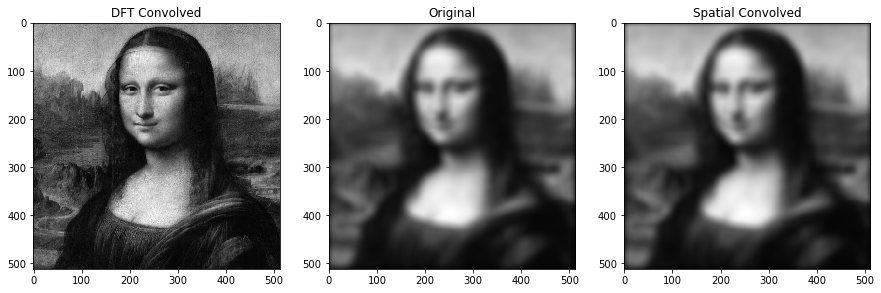

In [7]:
fig, axx = plt.subplots(1,3, figsize=(15,5))
axx[0].imshow(im_phase, cmap='gray')
axx[0].set_title("DFT Convolved")
axx[1].imshow(mona_conv, cmap='gray')
axx[1].set_title("Original")
axx[2].imshow(mona_conv_spatial, cmap='gray')
axx[2].set_title("Spatial Convolved");

###### Done

###### B:

In [8]:
def blend_phase(img1,img2):
    
    if img1.ndim == 3:
        img1 = np.copy(img_as_float(img1[...,0]))
    if img2.ndim == 3:
        img2 = np.copy(img_as_float(img2[...,0]))
        
    phase1 = np.fft.fft2(img1)
    phase1 = np.divide(phase1,np.absolute(phase1))
    magn = np.abs(np.fft.fft2(img2))
    
    blended = np.real(np.fft.ifft2(np.multiply(magn, phase1)))
    return img_as_float(blended)

In [9]:
blended_mona = blend_phase(im_phase, im_magnutide)
blended_ein = blend_phase(im_magnutide, im_phase)

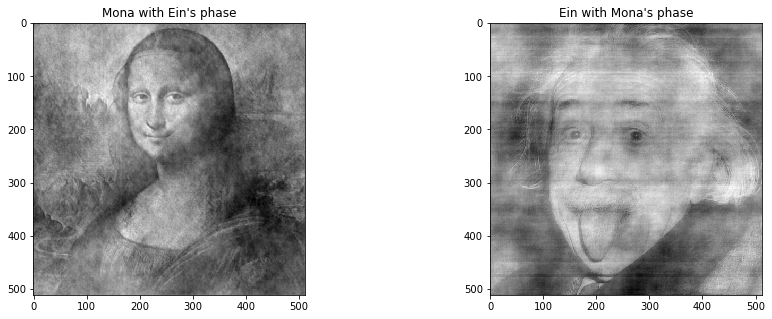

In [10]:
fig, axxx = plt.subplots(1,2, figsize=(15,5))
axxx[0].imshow(blended_mona, cmap='gray')
axxx[0].set_title("Mona with Ein's phase")
axxx[1].imshow(blended_ein, cmap='gray')
axxx[1].set_title("Ein with Mona's phase");

## Exercise 2: Laplacian Pyramid and its Application

Laplacian Image Pyramid is a perfect reconstruction image representation. It recovers the original image without any loss of information.

**The task:**

a) Implement the Laplacian pyramid algorithm according to the process describe in the lecture;

b) Using the Laplacian pyramid algorithm blend the given two images and plot the result.

**Image blending approach:**

1. Create a Laplacian pyramid $LA$ and $LB$ for each image;

2. Create a Gaussian pyramid $GR$ from selected region (according to mask);

3. Create a new Laplacian pyramid $LS$ as a weighted combination of the two, using node of the Gaussian pyramid as weights:

$$
LS(i, j) = GR(i, j) * LA(i, j) + (1 - GR(i, j)) * LB(i, j) ;
$$

4. Reconstruct the blended image from the new Laplacian pyramid.

**Source papers:**

http://persci.mit.edu/pub_pdfs/pyramid83.pdf (Laplacian and Gaussian pyramids)
http://www.cs.toronto.edu/~mangas/teaching/320/assignments/a3/spline83.pdf (Image Mosaics)
http://www.cs.toronto.edu/~jepson/csc320/notes/pyramids.pdf (Tutorial on Pyramids)

/home/art_mos/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


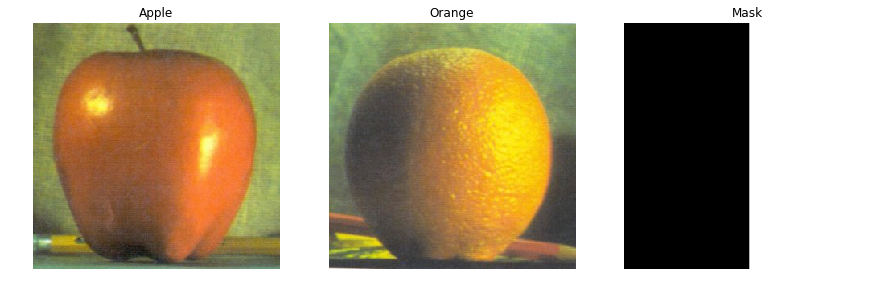

In [11]:
# read images

im_apple = scipy.misc.imread('images/apple.jpg')
im_orange = scipy.misc.imread('images/orange.jpg')
im_mask = scipy.misc.imread('images/mask.jpg')

# show images

fig, (sp_apple, sp_orange, sp_mask) = plt.subplots(1, 3, figsize=(15, 35))
sp_apple.imshow(im_apple)
sp_apple.set_title('Apple')
sp_apple.set_axis_off()
sp_orange.imshow(im_orange)
sp_orange.set_title('Orange')
sp_orange.set_axis_off()
sp_mask.imshow(im_mask, cmap='gray')
sp_mask.set_title('Mask')
sp_mask.set_axis_off()
fig.show()

In [12]:
def scale(img):
    if img.min() < 0:
        img = img - np.ones_like(img)*img.min()
    img = img/img.max()
    return img_as_float(img)

In [13]:
def Gaussian_piramyd(img, kernel, kernel_size_ds=2, threshold=9):
    img = np.copy(img_as_float(img))
    shapes = list()
    shapes.append(img.shape[:2])

    pyramid = list()
    pyramid.append(img)
    
    while True:
        convolved = convolve_2d(img, kernel)
        downsampled = downsample(convolved)
        pyramid.append(downsampled)
        img = np.copy(downsampled)
        shapes.append(img.shape[:2])
        if img.shape[0] <= threshold:
            break
    return pyramid, shapes

In [14]:
def downsample(img, kernel_size=2):
    img = np.copy(img_as_float(img))
    
    def do_ds(channel,kernel_size):
        #'''
        if channel.shape[0]%kernel_size != 0:
            channel = np.vstack((channel, np.zeros(channel.shape[1])))
        if channel.shape[1]%kernel_size != 0:
            channel = np.vstack((channel.T, np.zeros(channel.shape[0]))).T
        #'''
        if channel.shape[0]%kernel_size !=0 or channel.shape[1]%kernel_size !=0:
            print('Warning: Channel is not even dim!')

        kernel = np.zeros((kernel_size, kernel_size))
        kernel[0,0] = 1.
        
        
        convolved = np.zeros((int(channel.shape[0]/kernel_size), int(channel.shape[1]/kernel_size)))

        for conv_idx, i in enumerate(range(0,channel.shape[0],kernel_size)):
            for conv_jdx, j in enumerate(range(0,channel.shape[1],kernel_size)):
                image_segment = np.copy(channel[i:i+kernel_size,j:j+kernel_size])
                downsampled_value = np.multiply(image_segment, kernel).sum()
                convolved[conv_idx,conv_jdx] = np.copy(downsampled_value)
        return img_as_float(convolved)
    
    if img.ndim == 2:
        downsampled = do_ds(img, kernel_size=kernel_size)
    elif img.ndim == 3:
        c1, c2, c3 = img[:,:,0].copy(), img[:,:,1].copy(), img[:,:,2].copy()
        c1_ds = do_ds(c1, kernel_size=kernel_size)
        c2_ds = do_ds(c2, kernel_size=kernel_size)
        c3_ds = do_ds(c3, kernel_size=kernel_size)
        downsampled = np.stack([c1_ds, c2_ds, c3_ds], axis=2)
        
    return img_as_float(downsampled)

In [15]:
kernel_g1 = gaussian_kernel_2d(3,21)
gp,s = Gaussian_piramyd(im_orange, kernel_g1)

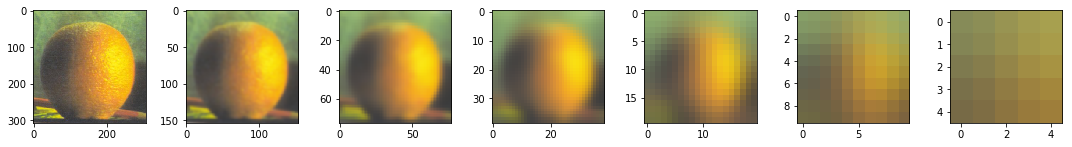

In [16]:
fig, ax = plt.subplots(1,len(gp), figsize=(15,5))

for i in range(len(gp)):
    ax[i].imshow(gp[i])
plt.tight_layout();

In [17]:
def upsample(img, kernel_size=2, output_size=False):
    img = np.copy(img_as_float(img))
    
    def do_us(img, kernel_size):
        upsampled = np.zeros((img.shape[0]*2,img.shape[1]*2))
        idxs = np.arange(0,upsampled.shape[0],2)
        jdxs = np.arange(0,upsampled.shape[1],2)
        for idx, i in enumerate(range(img.shape[0])):
            for jdx, j in enumerate(range(img.shape[1])):
                filler = np.ones((kernel_size,kernel_size))*img[i,j]
                f_i, f_j = idxs[idx], jdxs[jdx]
                upsampled[f_i:f_i+kernel_size, f_j:f_j+kernel_size] = np.copy(filler)
        return img_as_float(upsampled)
    
    def crop(img, output_size):
        row_dif, col_dif = np.abs(img.shape[0] - output_size[0]), np.abs(img.shape[1] - output_size[1])
        if row_dif:
            img = img[:-row_dif,:]
        if col_dif:
            img = img[:,:-col_dif]
        return img_as_float(img)
            
    if img.ndim == 2:
        img = do_us(img, kernel_size=kernel_size)
        if img.shape != output_size:
            img = crop(img, output_size)

    elif img.ndim == 3:
        c1,c2,c3 = img[:,:,0].copy(),img[:,:,1].copy(),img[:,:,2].copy()
        c1_us,c2_us,c3_us = do_us(c1, kernel_size=kernel_size), do_us(c2, kernel_size=kernel_size), do_us(c3, kernel_size=kernel_size)
        if c1_us.shape != output_size:
            c1_us,c2_us,c3_us = crop(c1_us, output_size), crop(c2_us, output_size), crop(c3_us, output_size)
        img = np.stack([c1_us, c2_us, c3_us], axis=2)
            
    return img_as_float(img)

In [18]:
def Laplacian_piramyd(img , kernel, kernel_size_ds=2,threshold=11):
    img = np.copy(img_as_float(img))
    GP, shapes = Gaussian_piramyd(img, kernel, kernel_size_ds=kernel_size_ds, threshold=threshold)
    laplacian_p = list()    
    GP, shapes = GP[::-1], shapes[::-1]
    
    for i in range(len(GP)-1):
        ups_img = upsample(GP[i], kernel_size=kernel_size_ds, output_size=shapes[i+1])
        ups_img = convolve_2d(ups_img, kernel=kernel)
        diff = GP[i+1] - ups_img
        laplacian_p.append(diff)

    return [GP[0]]+laplacian_p

In [19]:
lp_a=Laplacian_piramyd(im_apple, kernel_g1)
lp_o=Laplacian_piramyd(im_orange, kernel_g1)

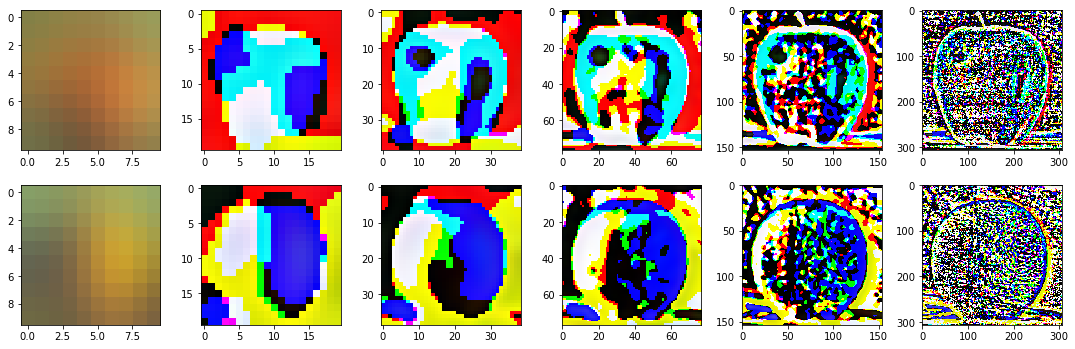

In [20]:
fig, ax_ = plt.subplots(2,len(lp_a), figsize=(15,5))

for i in range(len(lp_a)):
    ax_[0,i].imshow(lp_a[i])
    ax_[1,i].imshow(lp_o[i])
plt.tight_layout();

1. Create a Laplacian pyramid $LA$ and $LB$ for each image;

2. Create a Gaussian pyramid $GR$ from selected region (according to mask);

3. Create a new Laplacian pyramid $LS$ as a weighted combination of the two, using node of the Gaussian pyramid as weights:

$$
LS(i, j) = GR(i, j) * LA(i, j) + (1 - GR(i, j)) * LB(i, j) ;
$$

In [21]:
def blend(lp1_, lp2_, mask, kernel, kernel_size_ds=2,threshold=11):
    
    mask = img_as_float(np.stack([mask, mask, mask], axis=2))
    gpm,_ = Gaussian_piramyd(mask, kernel=kernel, kernel_size_ds=kernel_size_ds, threshold=threshold)
    gpm = gpm[::-1]
    lp1, lp2 = lp1_, lp2_
    lp=list()
    
    for k in range(len(lp1)):
        gpm_inv = 1 - gpm[k]
        combined = np.multiply(gpm[k], lp1[k]) + np.multiply(gpm_inv, lp2[k])
        lp.append(img_as_float(combined))
    return lp

In [22]:
kernel_g1 = gaussian_kernel_2d(3,11)
blended_img = blend(lp_o, lp_a, im_mask, kernel_g1)

###### joint laplacian pyramid:

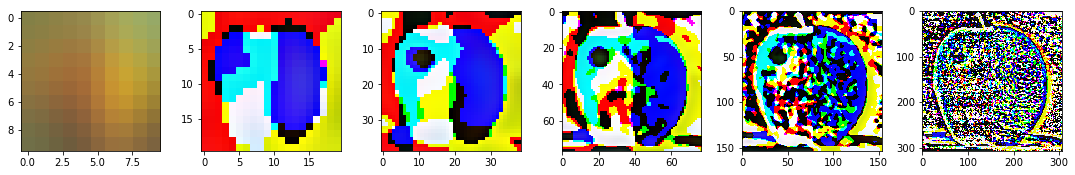

In [23]:
fig, ax2 = plt.subplots(1,len(blended_img), figsize=(15,5))

for i in range(len(blended_img)):
    ax2[i].imshow(blended_img[i])
plt.tight_layout();

###### reconstruction:

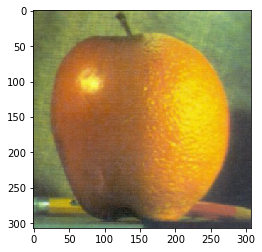

In [24]:
rec = blended_img[0]
for i in range(len(blended_img)-1):
    rec = upsample(rec, output_size=blended_img[i+1].shape[:2])
    rec = convolve_2d(rec, kernel_g1) + blended_img[i+1]
plt.imshow(scale(rec));

In [25]:
im_apple.shape == rec.shape

True

## Exercise 3: Image Approximation with Wavelets

**The task:**

a) Implement the Discrete Wavelet Transform (DWT) and its inverse IDWT for L-decomposition levels according to the process described during the lecture. 

b) Use the following sets of analysis and synthesis filters which satisfy the perfect reconstruction conditions and compute the DWT to the given image for $L=4$ decomposition levels. Discard $60%$, $80%$, $90%$, $95%$, $99%$ percent of the smallest detail coefficients (in absolute value) by setting them to zero, while the scaling coefficients (low-pass output of the final level of the recursive filterband) should remain untouched. Then reconstruct the image from the modified DWT coefficients. Plot the results and report what you observe. (For color images perform the DWT and IDWT for each color image channel independently)

**Daubechies 'db1' wavelets:**

Decomposition low-pass filter:
$$
\begin{bmatrix} 0.7071 & 0.7071 \end{bmatrix}
$$

Decomposition high-pass filter:
$$
\begin{bmatrix} -0.7071 & 0.7071 \end{bmatrix}
$$

Reconstruction low-pass filter:
$$
\begin{bmatrix} 0.7071 & 0.7071 \end{bmatrix}
$$

Reconstruction high-pass filter:
$$
\begin{bmatrix} 0.7071 & -0.7071 \end{bmatrix}
$$

**Daubechies 'db5' wavelets:**

Decomposition low-pass filter:
$$
\begin{bmatrix} 0.0033 &  -0.0126 &  -0.0062  &  0.0776 &  -0.0322 &  -0.2423  &  0.1384 &   0.7243 &   0.6038 &  0.1601 \end{bmatrix}
$$

Decomposition high-pass filter:
$$
\begin{bmatrix} -0.1601  &  0.6038 &  -0.7243  &  0.1384  &  0.2423 &  -0.0322 &  -0.0776 &  -0.0062  &  0.0126 &    0.0033 \end{bmatrix}
$$

Reconstruction low-pass filter:
$$
\begin{bmatrix}  0.1601 &   0.6038  &  0.7243  &  0.1384 &  -0.2423  & -0.0322 &   0.0776  & -0.0062 &  -0.0126  &  0.0033 \end{bmatrix}
$$

Reconstruction high-pass filter:
$$
\begin{bmatrix}  0.0033 &   0.0126 &  -0.0062 &  -0.0776 &  -0.0322  &  0.2423  &  0.1384 &  -0.7243 &   0.6038  & -0.1601 \end{bmatrix}
$$

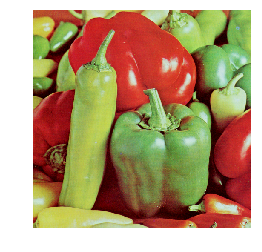

In [26]:
# read image

im_peppers = scipy.misc.imread('images/peppers.png')

plt.imshow(im_peppers)
plt.axis('off')
plt.show()

In [27]:
def convolve_2d(image, kernel, mode='same', boundary='wrap'):
    image = np.copy(img_as_float(image))
    
    if image.ndim == 2:
        d1 = image.copy()
        convolved = convolve2d(in1=image, in2=kernel, boundary=boundary, mode=mode)
    elif image.ndim == 3:
        d1, d2, d3 = image[:,:,0].copy(), image[:,:,1].copy(), image[:,:,2].copy()
        convolved0 = convolve2d(in1=d1, in2=kernel, boundary=boundary, mode=mode)
        convolved1 = convolve2d(in1=d2, in2=kernel, boundary=boundary, mode=mode)
        convolved2 = convolve2d(in1=d3, in2=kernel, boundary=boundary, mode=mode)
        convolved = np.stack([convolved0,convolved1,convolved2], axis=2)
    return scale(img_as_float(convolved))

In [28]:
low_pass_filter=np.array([0.7071, 0.7071]).reshape(1,-1)
high_pass_filter=np.array([-0.7071,0.7071]).reshape(1,-1)

In [29]:
def DWT(img, low_pass_filter, high_pass_filter, L):
    
    def get_path_matricies(L):
        matrix_pathes = list()
        main = np.zeros((4,2*L))
        path_filler = np.array([[0,1],[1,0],[1,1]])
        main[1:,-2:] = path_filler
        matrix_pathes.append(main)
        for i in range(1,L):
            mat = np.zeros((3,2*L-2*i))
            mat[:,-2:] = path_filler
            matrix_pathes.append(mat)
        return matrix_pathes
    
    pathes_matrix = get_path_matricies(L)
    
    def convolve_with_path(path, img, low_pass_filter, high_pass_filter):
        #col - row
        img = np.copy(img_as_float(img))
        for i, each_step in enumerate(path):

            if each_step:
                current_kernel = high_pass_filter #row vector
            else:
                current_kernel = low_pass_filter #row vector

            if i%2==0: #col
                img = convolve_2d(img, current_kernel.T)
            else: #row
                img = convolve_2d(img, current_kernel)

            img = downsample(img)

        return img_as_float(img)
    
    wavelet_list = list()
    for each_path_matrix in pathes_matrix:
        for each_path_row in each_path_matrix:
            current_wavelet = convolve_with_path(path=each_path_row, img=img, low_pass_filter=low_pass_filter, high_pass_filter=high_pass_filter)
            wavelet_list.append(current_wavelet)
    return wavelet_list

In [30]:
dwt_list=DWT(im_peppers, low_pass_filter, high_pass_filter, L=3)

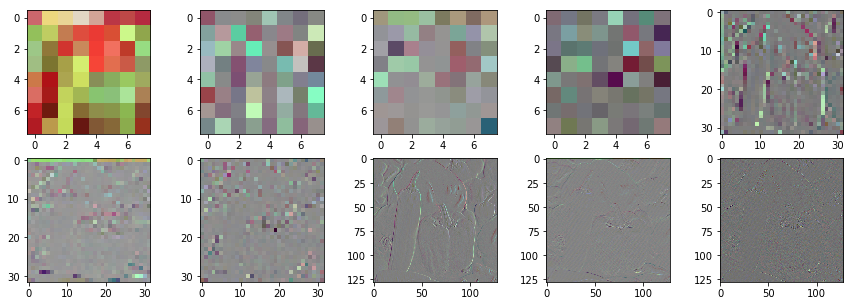

In [31]:
fig, aw = plt.subplots(2,5, figsize=(15,5))

aw[0,0].imshow(dwt_list[0])
aw[0,1].imshow(dwt_list[1])
aw[0,2].imshow(dwt_list[2])
aw[0,3].imshow(dwt_list[3])
aw[0,4].imshow(dwt_list[4])

aw[1,0].imshow(dwt_list[5])
aw[1,1].imshow(dwt_list[6])
aw[1,2].imshow(dwt_list[7])
aw[1,3].imshow(dwt_list[8])
aw[1,4].imshow(dwt_list[9]);

In [32]:
len(dwt_list)

10

##### DWT is done. I just need to find a good way to visualize and reconstruct